In [51]:
# Import required  libraries
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
# Auxiliary functions
def read_api_key(filepath):
    with open(filepath, 'r') as f:
        return f.read().strip()

def download_esios_indicators(api_key_file):
    api_key = read_api_key(api_key_file)
    url = "https://api.esios.ree.es/indicators"
    headers = {
        "Accept": "application/json; application/vnd.esios-api-v1+json",
        "Content-Type": "application/json",
        "x-api-key": f"{api_key}"
    }
    response = requests.get(url, headers=headers)
    response.raise_for_status()
    return response.json()

def download_esios_indicator_data(api_key_file, indicator_id, start_date, end_date):
    """
    Download data for a specific indicator from ESIOS API within a date range.
    
    Parameters:
    - api_key_file: Path to the file containing the API key
    - indicator_id: ID of the indicator to download
    - start_date: Start date in format 'YYYY-MM-DDTHH:MM:SS'
    - end_date: End date in format 'YYYY-MM-DDTHH:MM:SS'
    
    Returns:
    - JSON response with indicator data
    """
    api_key = read_api_key(api_key_file)
    url = f"https://api.esios.ree.es/indicators/{indicator_id}"
    headers = {
        "Accept": "application/json; application/vnd.esios-api-v1+json",
        "Content-Type": "application/json",
        "x-api-key": f"{api_key}"
    }
    params = {
        "start_date": start_date,
        "end_date": end_date
    }
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()

def get_esios_indicator_dataframe(indicator_id, start_date, end_date, api_key_file="esios_api_key.txt", verbose=False):
    """
    Download ESIOS indicator data and return as pandas DataFrame.
    
    Parameters:
    - indicator_id: ID of the indicator to download
    - start_date: Start date in format 'YYYY-MM-DDTHH:MM:SS'
    - end_date: End date in format 'YYYY-MM-DDTHH:MM:SS'
    - api_key_file: Path to the file containing the API key (default: "esios_api_key.txt")
    - verbose: Boolean flag to print detailed information (default: False)
    
    Returns:
    - pandas DataFrame with datetime and value columns
    """
    try:
        # Download the data using the existing function
        indicator_data = download_esios_indicator_data(api_key_file, indicator_id, start_date, end_date)
        
        if verbose:
            print(f"Downloaded data for indicator {indicator_id} ({indicator_data['indicator']['magnitud'][0]['name']})")
            print(f"Data points: {len(indicator_data['indicator']['values'])}")
            print(f"First few values:")
            for i, value in enumerate(indicator_data['indicator']['values'][:5]):
                print(f"  {value['datetime']}: {value['value']}")
        
        # Extract datetime and value from indicator_data
        df = pd.DataFrame(indicator_data['indicator']['values'])
        df['datetime'] = pd.to_datetime(df['datetime'])

        return df, indicator_data['indicator']['magnitud'][0]['name']

    except Exception as e:
        if verbose:
            print(f"Error downloading data: {e}")
        raise e

def calculate_forecast_errors(actual_df, forecast_df, datetime_col='datetime', value_col='value'):
    """
    Calculate multiple forecast error metrics: MAE, RMSE, and MAPE.
    
    Parameters:
    - actual_df: DataFrame with actual values
    - forecast_df: DataFrame with forecasted values  
    - datetime_col: Column name for datetime (default: 'datetime')
    - value_col: Column name for values (default: 'value')
    
    Returns:
    - Dictionary with error metrics: {'mae': float, 'rmse': float, 'mape': float}
    - merged_df: DataFrame with aligned actual and forecast values
    """
    # Merge dataframes on datetime to ensure alignment
    merged_df = pd.merge(actual_df, forecast_df, on=datetime_col, suffixes=('_actual', '_forecast'))
    
    # Calculate errors
    errors = merged_df[f'{value_col}_actual'] - merged_df[f'{value_col}_forecast']
    absolute_errors = abs(errors)
    squared_errors = errors ** 2
    
    # Calculate MAE (Mean Absolute Error)
    mae = absolute_errors.mean()
    
    # Calculate RMSE (Root Mean Squared Error)
    rmse = (squared_errors.mean()) ** 0.5
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    # Remove rows where actual value is zero to avoid division by zero
    non_zero_actual = merged_df[merged_df[f'{value_col}_actual'] != 0].copy()
    
    if len(non_zero_actual) == 0:
        raise ValueError("All actual values are zero. MAPE cannot be calculated.")
    
    # Calculate absolute percentage errors for non-zero actual values
    absolute_percentage_errors = abs(
        (non_zero_actual[f'{value_col}_actual'] - non_zero_actual[f'{value_col}_forecast']) / 
        non_zero_actual[f'{value_col}_actual']
    ) * 100
    
    mape = absolute_percentage_errors.mean()
    
    # Return results as dictionary
    error_metrics = {
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    }
    
    return error_metrics, merged_df

# Keep individual functions for backward compatibility
def calculate_mae(actual_df, forecast_df, datetime_col='datetime', value_col='value'):
    """Calculate Mean Absolute Error - wrapper for backward compatibility."""
    error_metrics, merged_df = calculate_forecast_errors(actual_df, forecast_df, datetime_col, value_col)
    return error_metrics['mae'], merged_df

def calculate_rmse(actual_df, forecast_df, datetime_col='datetime', value_col='value'):
    """Calculate Root Mean Squared Error - wrapper for backward compatibility."""
    error_metrics, merged_df = calculate_forecast_errors(actual_df, forecast_df, datetime_col, value_col)
    return error_metrics['rmse'], merged_df

def calculate_mape(actual_df, forecast_df, datetime_col='datetime', value_col='value'):
    """Calculate Mean Absolute Percentage Error - wrapper for backward compatibility."""
    error_metrics, merged_df = calculate_forecast_errors(actual_df, forecast_df, datetime_col, value_col)
    return error_metrics['mape'], merged_df

In [53]:
# Example usage:
indicators = download_esios_indicators('esios_api_key.txt')
print(indicators)

{'indicators': [{'name': 'Generación programada PBF Hidráulica UGH', 'description': '<p>Es el programa de energía diario, con desglose horario, de las diferentes Unidades de Programación correspondientes a ventas y adquisiciones de energía en el sistema eléctrico peninsular español. En concreto este indicador se refiere a las unidades de programación con tipo de producción hidráulica UGH.</p><p>Este programa es establecido por el OS a partir de la casación del OM y de las nominaciones de programas de todas y cada una de las Unidades de Programación que le han sido comunicadas por los sujetos titulares de dichas Unidades de Programación, incluyendo las correspondientes a la ejecución de contratos bilaterales con entrega física de los cuales se ha confirmado la ejecución.</p><p><b>Publicación:</b> diariamente a partir de las 13:45 horas con la información del día D+1.</p>', 'short_name': 'Hidráulica UGH', 'id': 1}, {'name': 'Generación programada PBF Hidráulica no UGH', 'description': '<

In [54]:
# Example: Download specific indicator data with date range
# Let's download data for indicator 1293 (Demanda real - Real demand) 
# Other indicators of interest (545 Demanda Programada - Scheduled Demand; 
#                               544 Demanda Prevista - Forecasted Demand)
# for the last week of July 2025

demand_indicator_id = 1293  # Real demand indicator
forecast_indicator_id = 544  # Forecasted demand indicator
start_date = "2025-07-24T00:00:00"
end_date = "2025-07-25T23:59:59"


try:
    demand_df, demand_label = get_esios_indicator_dataframe(demand_indicator_id, start_date, end_date, verbose=True)
    forecast_df, forecast_label = get_esios_indicator_dataframe(forecast_indicator_id, start_date, end_date, verbose=True)
except Exception as e:
    print(f"Error downloading data: {e}")
print ("Downloaded Data")

Downloaded data for indicator 1293 (Potencia)
Data points: 576
First few values:
  2025-07-24T00:00:00.000+02:00: 28268.0
  2025-07-24T00:05:00.000+02:00: 28375.0
  2025-07-24T00:10:00.000+02:00: 28322.0
  2025-07-24T00:15:00.000+02:00: 28430.0
  2025-07-24T00:20:00.000+02:00: 28107.0
Downloaded data for indicator 544 (Potencia)
Data points: 576
First few values:
  2025-07-24T00:00:00.000+02:00: 28563.0
  2025-07-24T00:05:00.000+02:00: 28461.0
  2025-07-24T00:10:00.000+02:00: 28358.0
  2025-07-24T00:15:00.000+02:00: 28256.0
  2025-07-24T00:20:00.000+02:00: 28155.0
Downloaded Data
Downloaded data for indicator 544 (Potencia)
Data points: 576
First few values:
  2025-07-24T00:00:00.000+02:00: 28563.0
  2025-07-24T00:05:00.000+02:00: 28461.0
  2025-07-24T00:10:00.000+02:00: 28358.0
  2025-07-24T00:15:00.000+02:00: 28256.0
  2025-07-24T00:20:00.000+02:00: 28155.0
Downloaded Data


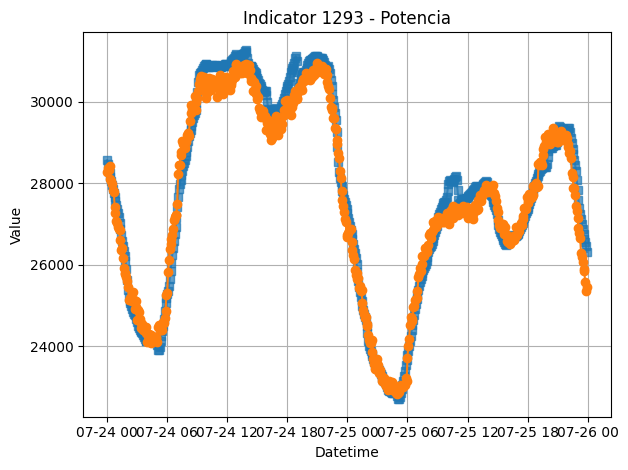

In [55]:
# Plot both demand and forecast data
plt.plot(forecast_df['datetime'], forecast_df['value'], marker='s', label=f"{forecast_indicator_id} - {forecast_label}", alpha=0.7)
plt.plot(demand_df['datetime'], demand_df['value'], marker='o', label=f"{demand_indicator_id} - {demand_label}")
plt.title(f"Indicator {demand_indicator_id} - {demand_label}")
plt.xlabel("Datetime")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [59]:
# Calculate all forecast error metrics using the combined function
error_metrics, merged_comparison = calculate_forecast_errors(demand_df, forecast_df)

# Extract individual metrics
mae = error_metrics['mae']
rmse = error_metrics['rmse']
mape = error_metrics['mape']

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Number of compared data points: {len(merged_comparison)}")

# Display some statistics
print(f"\nComparison Statistics:")
print(f"Average actual demand: {merged_comparison['value_actual'].mean():.2f}")
print(f"Average forecasted demand: {merged_comparison['value_forecast'].mean():.2f}")
print(f"Standard deviation of errors: {abs(merged_comparison['value_actual'] - merged_comparison['value_forecast']).std():.2f}")
print(f"Maximum absolute error: {abs(merged_comparison['value_actual'] - merged_comparison['value_forecast']).max():.2f}")

# Calculate relative errors (as percentage) - only for MAE and RMSE
relative_mae = (mae / merged_comparison['value_actual'].mean()) * 100
relative_rmse = (rmse / merged_comparison['value_actual'].mean()) * 100
print(f"Relative MAE: {relative_mae:.2f}%")
print(f"Relative RMSE: {relative_rmse:.2f}%")

# Error metrics comparison
print(f"\nError Metrics Comparison:")
print(f"RMSE/MAE ratio: {rmse/mae:.2f}")
if rmse > mae:
    print("RMSE > MAE indicates presence of larger errors (outliers)")
else:
    print("RMSE ≈ MAE indicates relatively uniform error distribution")

print(f"\nMAPE Interpretation:")
if mape < 10:
    print("MAPE < 10%: Highly accurate forecast")
elif mape < 20:
    print("MAPE 10-20%: Good forecast")
elif mape < 50:
    print("MAPE 20-50%: Reasonable forecast")
else:
    print("MAPE > 50%: Inaccurate forecast")

Mean Absolute Error (MAE): 313.16
Root Mean Squared Error (RMSE): 385.93
Mean Absolute Percentage Error (MAPE): 1.12%
Number of compared data points: 576

Comparison Statistics:
Average actual demand: 27614.15
Average forecasted demand: 27751.35
Standard deviation of errors: 225.74
Maximum absolute error: 1107.00
Relative MAE: 1.13%
Relative RMSE: 1.40%

Error Metrics Comparison:
RMSE/MAE ratio: 1.23
RMSE > MAE indicates presence of larger errors (outliers)

MAPE Interpretation:
MAPE < 10%: Highly accurate forecast


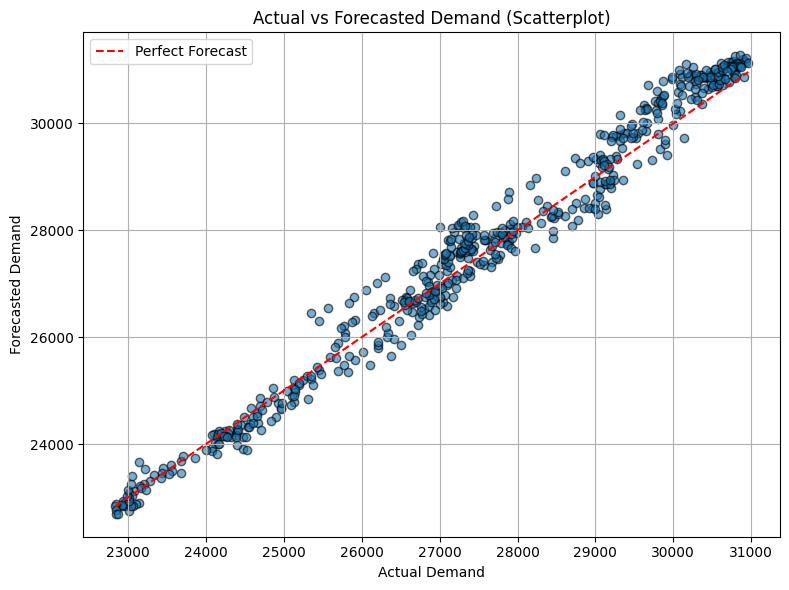

In [ ]:
# Enhanced scatterplot of the actual vs forecasted demand
plt.figure(figsize=(10, 8))

# Create the scatter plot
scatter = plt.scatter(merged_comparison['value_actual'], merged_comparison['value_forecast'], 
                     alpha=0.6, edgecolor='k', s=50, c='blue', label='Data Points')

# Perfect forecast line (diagonal)
min_val = min(merged_comparison['value_actual'].min(), merged_comparison['value_forecast'].min())
max_val = max(merged_comparison['value_actual'].max(), merged_comparison['value_forecast'].max())
plt.plot([min_val, max_val], [min_val, max_val], 
         color='red', linestyle='--', linewidth=2, label='Perfect Forecast')

# Add correlation coefficient
correlation = merged_comparison['value_actual'].corr(merged_comparison['value_forecast'])

# Labels and title
plt.xlabel('Actual Demand', fontsize=12)
plt.ylabel('Forecasted Demand', fontsize=12)
plt.title(f'Actual vs Forecasted Demand\nCorrelation: {correlation:.3f} | MAE: {mae:.2f} | MAPE: {mape:.1f}%', 
          fontsize=14)

# Add grid and legend
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Make axes equal for better comparison
plt.axis('equal')
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

plt.tight_layout()
plt.show()

# Print correlation and R-squared
r_squared = correlation ** 2
print(f"Correlation coefficient (R): {correlation:.4f}")
print(f"Coefficient of determination (R²): {r_squared:.4f}")
print(f"R² interpretation: {r_squared*100:.1f}% of variance in actual demand is explained by the forecast")


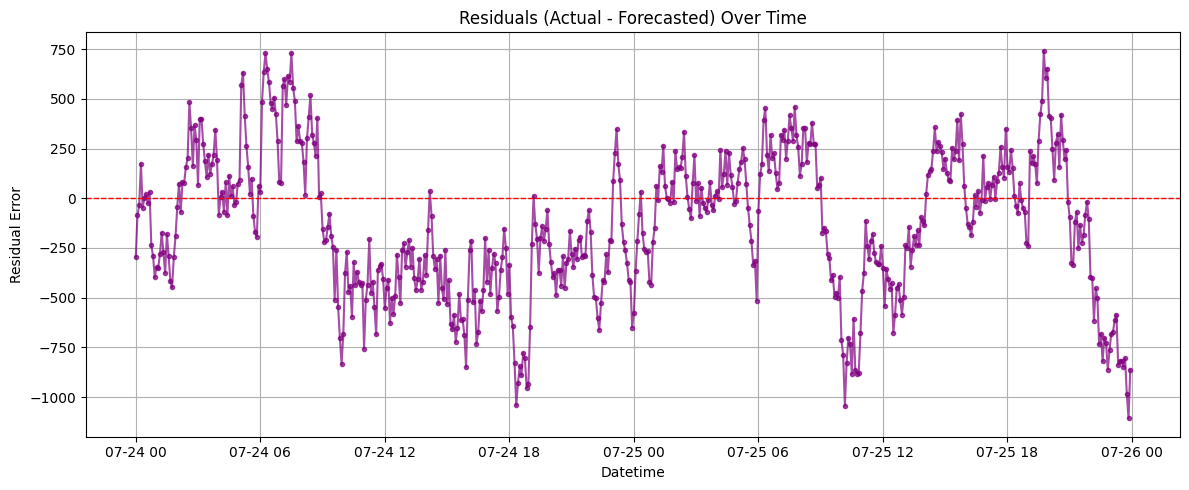

In [61]:
# Plot residuals (actual - forecasted) over time
residuals = merged_comparison['value_actual'] - merged_comparison['value_forecast']
plt.figure(figsize=(12, 5))
plt.plot(merged_comparison['datetime'], residuals, marker='.', linestyle='-', color='purple', alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title('Residuals (Actual - Forecasted) Over Time')
plt.xlabel('Datetime')
plt.ylabel('Residual Error')
plt.grid(True)
plt.tight_layout()
plt.show()